# Libraries
* Standard libraries: numpy, pandas
* Data viz: matplotlib, seaborn
* Model + metrics: sklearn, xgboost, shap

In [1]:
# Import your libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import shap
shap.initjs()

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# Strategy
1. overview of features & dtypes
   1. size of data set
   2. type of data
2. missing data + imposing 
3. finding distributions
   1. range and std
   2. correlation matrix
4. choose + build model
5. get baseline shap values
6. reiterate for feature selection/importance

In [3]:
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e3/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [4]:
train.columns

Index(['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp',
       'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection',
       'windspeed', 'rainfall'],
      dtype='object')

In [5]:
display(train.head())
display(test.head())

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [6]:
print('Shape of train data',train.shape)
print('Shape of test data',test.shape)
# shape -> (nrows, ncols)

Shape of train data (2190, 13)
Shape of test data (730, 12)


In [7]:
display(train.describe())
display(test.describe())
# verify that train has the column 'rainfall' and test does not.

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,1094.500000,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,632.342866,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,0.000000,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,547.250000,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,1094.500000,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,1641.750000,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,2189.000000,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,729.000000,730.000000
mean,2554.500000,183.000000,1013.503014,26.372466,23.963288,22.110274,20.460137,82.669863,76.360274,3.664384,103.923182,22.484247
std,210.877136,105.438271,5.505871,5.672521,5.278098,5.170744,5.391169,7.818714,17.934121,3.639272,81.695458,9.954779
min,2190.000000,1.000000,1000.000000,7.400000,5.900000,4.200000,-0.000000,39.000000,0.000000,0.000000,10.000000,4.500000
25%,2372.250000,92.000000,1008.725000,21.600000,19.825000,17.825000,16.800000,77.250000,69.000000,0.325000,40.000000,14.500000
50%,2554.500000,183.000000,1012.700000,27.800000,25.650000,23.900000,22.300000,82.000000,83.000000,2.200000,70.000000,21.300000
75%,2736.750000,274.000000,1017.600000,31.000000,28.375000,26.400000,25.000000,89.000000,88.000000,6.675000,200.000000,28.400000
max,2919.000000,365.000000,1032.200000,35.800000,31.800000,29.100000,26.700000,98.000000,100.000000,11.800000,300.000000,59.500000


In [8]:
train.dtypes
# everything is numerical, there are no categorical columns

id                 int64
day                int64
pressure         float64
maxtemp          float64
temparature      float64
mintemp          float64
dewpoint         float64
humidity         float64
cloud            float64
sunshine         float64
winddirection    float64
windspeed        float64
rainfall           int64
dtype: object

In [9]:
train.isna().sum()
# there is no missing data either!

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

In [10]:
test.isna().sum()
# if we decide to use 'winddirection' this row can be removed

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

In [11]:
test.loc[test.winddirection.isna(),:]
# here corresponding row for the missing winddirection entry

invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
517,2707,153,1007.8,32.9,30.6,28.9,22.0,65.0,75.0,8.2,NaN,17.2


In [12]:
train.dropna()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2185,361,1014.6,23.2,20.6,19.1,19.9,97.0,88.0,0.1,40.0,22.1,1
2186,2186,362,1012.4,17.2,17.3,16.3,15.3,91.0,88.0,0.0,50.0,35.3,1
2187,2187,363,1013.3,19.0,16.3,14.3,12.6,79.0,79.0,5.0,40.0,32.9,1
2188,2188,364,1022.3,16.4,15.2,13.8,14.7,92.0,93.0,0.1,40.0,18.0,1


[Text(0.5, 1.0, 'windspeed')]

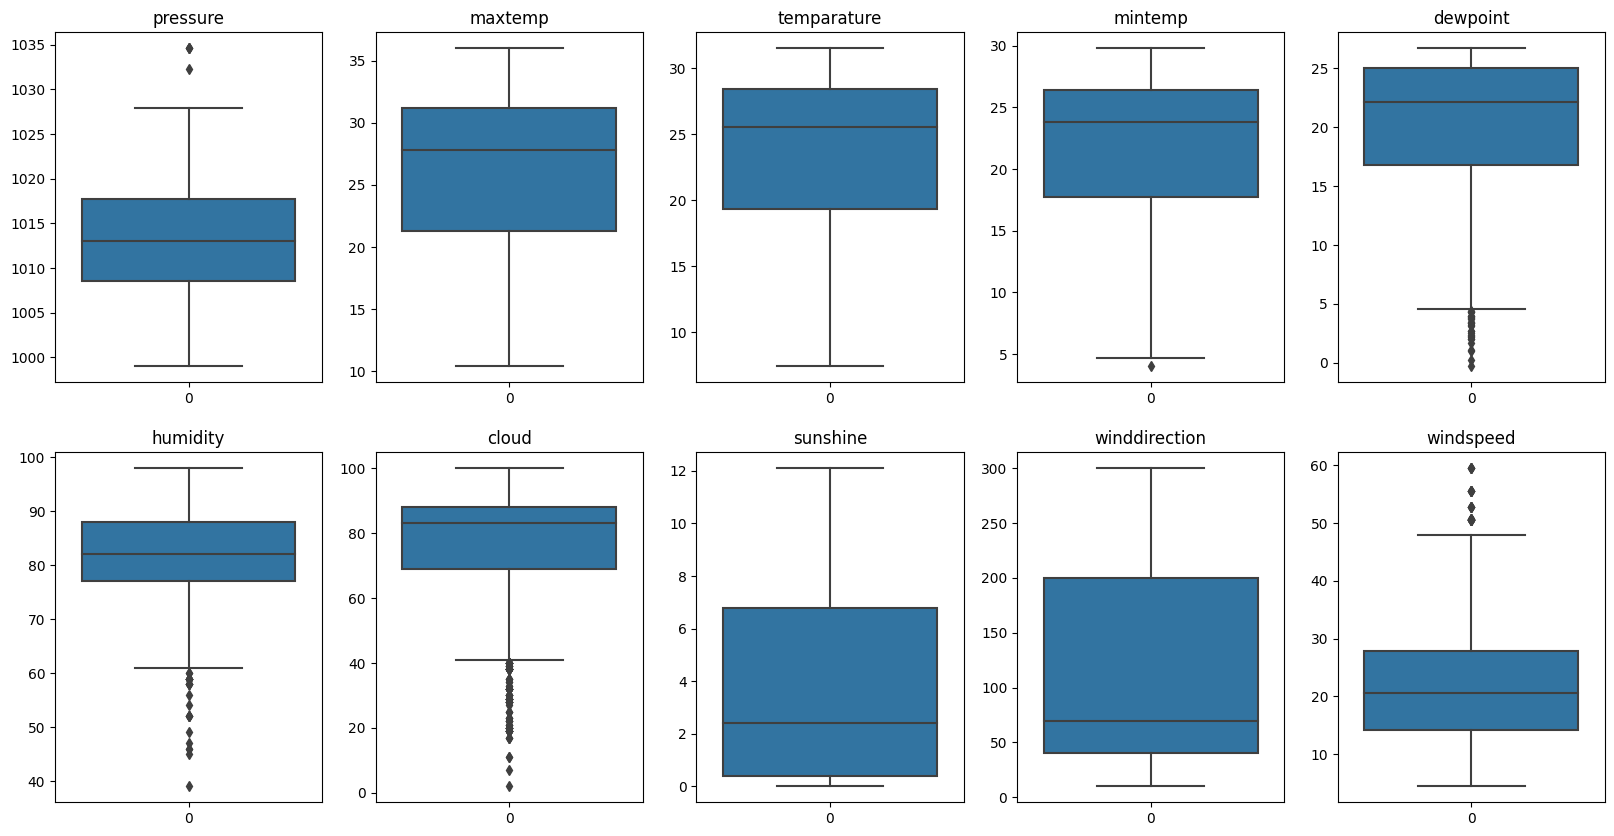

In [13]:
fig,ax = plt.subplots(2,5, figsize = (20,10))
sns.boxplot(data = train.iloc[:,2], ax = ax[0,0]).set(title = train.columns[2])
sns.boxplot(data = train.iloc[:,3], ax = ax[0,1]).set(title = train.columns[3])
sns.boxplot(data = train.iloc[:,4], ax = ax[0,2]).set(title = train.columns[4])
sns.boxplot(data = train.iloc[:,5], ax = ax[0,3]).set(title = train.columns[5])
sns.boxplot(data = train.iloc[:,6], ax = ax[0,4]).set(title = train.columns[6])
sns.boxplot(data = train.iloc[:,7], ax = ax[1,0]).set(title = train.columns[7])
sns.boxplot(data = train.iloc[:,8], ax = ax[1,1]).set(title = train.columns[8])
sns.boxplot(data = train.iloc[:,9], ax = ax[1,2]).set(title = train.columns[9])
sns.boxplot(data = train.iloc[:,10], ax = ax[1,3]).set(title = train.columns[10])
sns.boxplot(data = train.iloc[:,11], ax = ax[1,4]).set(title = train.columns[11])
# outliers in pressure, dewpoint, humidity, cloud, windspeed
# how should these be handled?

<Axes: >

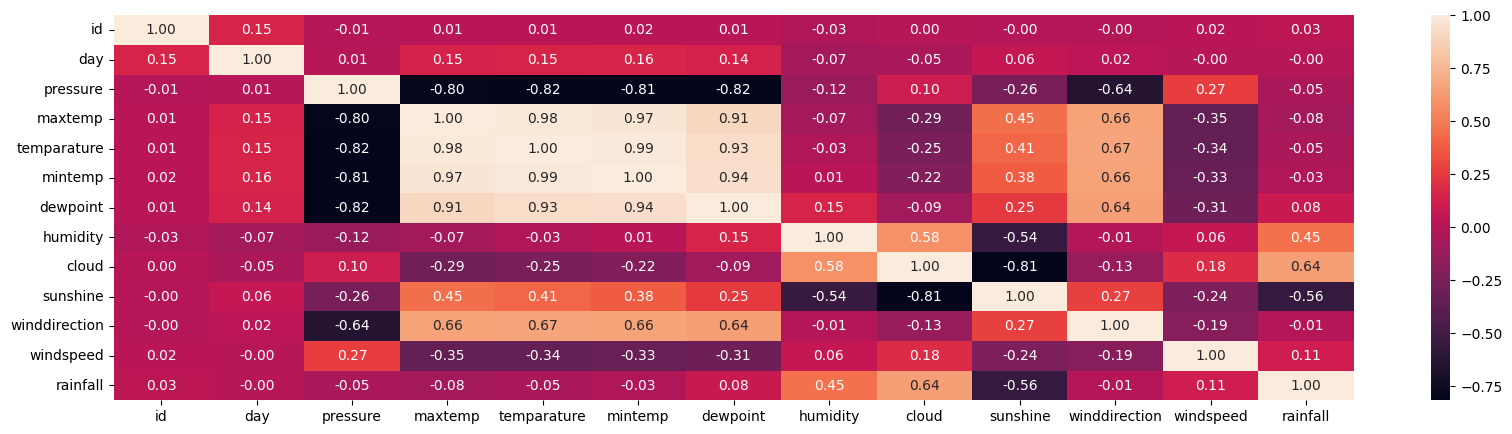

In [14]:
plt.subplots(figsize = (20,5))
sns.heatmap(train.corr(), annot = True, fmt='.2f')

Text(0.5, 1.0, 'dewpoint')

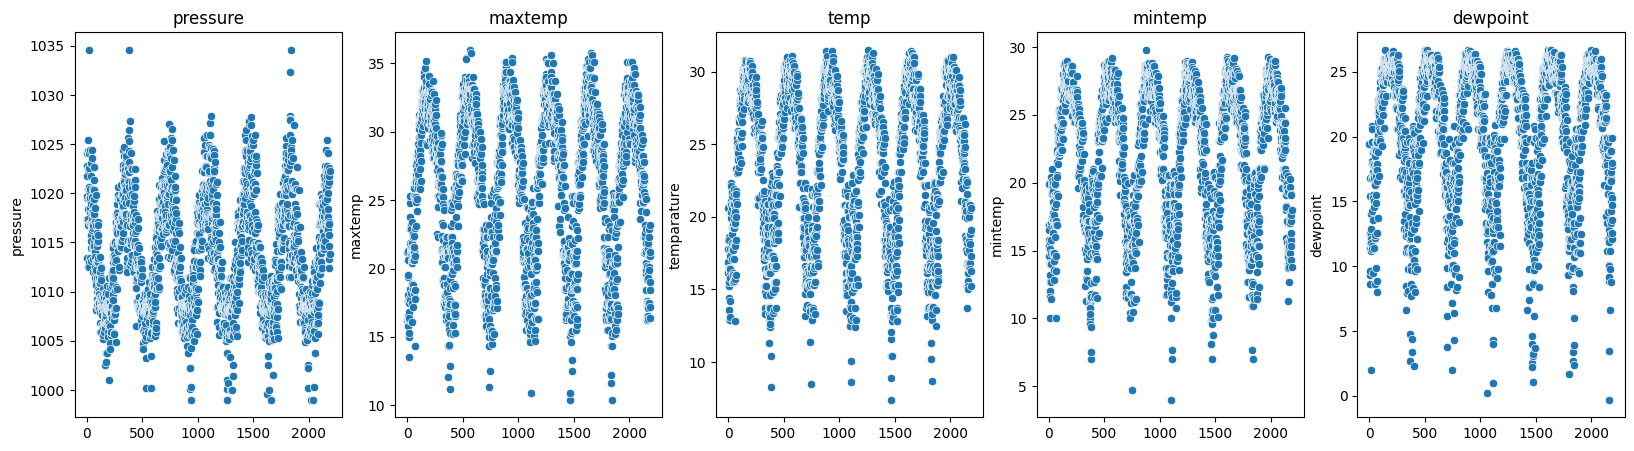

In [15]:
f,ax = plt.subplots(1,5, figsize = (20,5))
sns.scatterplot(data = train.pressure, ax = ax[0]).set_title('pressure')
sns.scatterplot(data = train.maxtemp,ax = ax[1]).set_title('maxtemp')
sns.scatterplot(data = train.temparature,ax = ax[2]).set_title('temp')
sns.scatterplot(data = train.mintemp,ax = ax[3]).set_title('mintemp')
sns.scatterplot(data = train.dewpoint,ax = ax[4]).set_title('dewpoint')
# these highly correlated features are harmonic

In [16]:
# split data x,y
xTrain = train.iloc[:,1:12]
yTrain_full = train.loc[:,'rainfall']

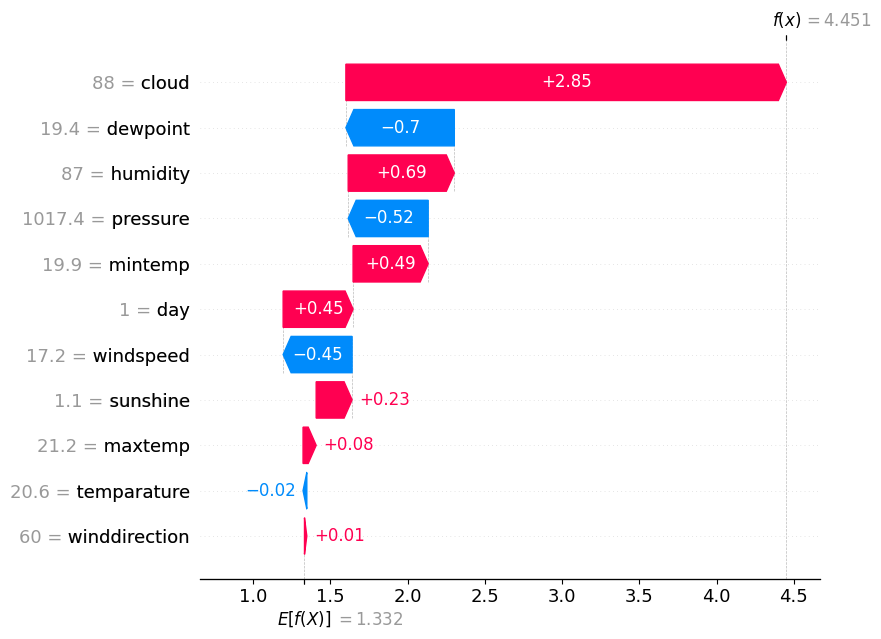

In [17]:
# model = xgb.XGBClassifier(objective = "binary:logistic")
model = xgb.XGBClassifier()
model.fit(xTrain, yTrain_full)

explainer = shap.Explainer(model)
shapVals = explainer(xTrain)
shap.plots.waterfall(shapVals[0], max_display = 11)
shap.plots.force(shapVals[0])

# Cross Validating
* What is cross validating?
* How do I interpret the output?
* What should I do next?

In [18]:
# choose best features and rerun model?
# cloud, dewpoint, humidity, pressure, mintemp

In [19]:
myCols = ['cloud', 'dewpoint', 'humidity', 'pressure', 'mintemp', 'day', 'windspeed']
xTrain_myCols = xTrain[myCols]
xTrain, xValid, yTrain, yValid = train_test_split(xTrain_myCols, yTrain_full, test_size = 0.75)

In [20]:
XGBClf = xgb.XGBClassifier()
RFClf = RandomForestClassifier()
SGDClf = SGDClassifier()
SVClf = SVC(kernel = 'linear')
logClf = LogisticRegression()

In [21]:
print('CV score for SGDC:',cross_val_score(SGDClf, xTrain_myCols, yTrain_full))
print('CV score for XGBC:',cross_val_score(XGBClf, xTrain_myCols, yTrain_full))
print('CV score for RFC:',cross_val_score(RFClf, xTrain_myCols, yTrain_full))
print('CV score for SVC:',cross_val_score(SVClf, xTrain_myCols, yTrain_full))
print('CV score for logClf:',cross_val_score(logClf, xTrain_myCols, yTrain_full))

CV score for SGDC: [0.81506849 0.83333333 0.30593607 0.61643836 0.85159817]
CV score for XGBC: [0.84018265 0.83333333 0.85388128 0.85159817 0.82876712]
CV score for RFC: [0.84474886 0.8630137  0.86986301 0.8630137  0.85616438]
CV score for SVC: [0.84474886 0.86073059 0.88812785 0.8652968  0.84018265]
CV score for logClf: [0.84246575 0.8652968  0.88584475 0.86757991 0.84246575]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [22]:
logClf.fit(xTrain, yTrain)
ROC_AUC = roc_auc_score(yValid, logClf.decision_function(xValid))
print('ROC_AUC_SCORE using logClf:',ROC_AUC)

ROC_AUC_SCORE using logClf: 0.890193028925988


In [23]:
xTest = test[myCols]
clf = LogisticRegression()
clf.fit(xTrain_myCols, yTrain_full)
yTestPred = clf.predict(xTest)

In [24]:
submission = test.copy()
submission['rainfall'] = yTestPred
submission = submission[['id','rainfall']]
submission.to_csv('submission.csv', index = False)